In [27]:
import os
import random
import shutil
from collections import defaultdict
from PIL import Image, ImageEnhance, ImageOps, ImageFilter, ImageOps
import matplotlib.pyplot as plt
import numpy as np

# ------------------- Torch --------------------------------#
import torch
from torchvision.transforms.functional import to_pil_image
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

- Traverse through each subfolder in the root directory.
- Count the number of images in each subfolder.
- Determine the minimum number of images among all the subfolders.
- Calculate the number of images to allocate for each category (train, val, test) based on the minimum count and the desired distribution.
- Create new folders (train, val, test) if they don't exist already.
- Copy the required number of images from each subfolder to the respective category folders, maintaining the desired distribution.

In [28]:
# Howto:
# https://medium.com/@siromermer/pipeline-for-every-pytorch-image-classification-problem-creating-dataset-f0f57d6ae225

# Code directories

In [29]:
root_dir = '../Downloading_images/data/'

In [30]:
# path to train and validation sets
train_dir= "../Downloading_images/data/train/" # path to the train folder
validation_dir= "../Downloading_images/data/val" # path to the validation folder
test_dir= "../Downloading_images/data/test" # path to the test folder

In [31]:
# variables for the paths.
train_dir = train_dir
validation_dir = validation_dir
test_dir = test_dir

In [32]:
# Define the path to the models folder
models_folder = './models/'

# Transform the data

In [33]:
width = 224
height = 224

train_transform  = transforms.Compose([
    # Resize Image
    transforms.Resize(size=(width, height)), 
    # Turn the image into a torch.
    transforms.ToTensor() 
])


validation_transform  = transforms.Compose([
transforms.Resize(size=(width, height)),
transforms.ToTensor()  
])

test_transform  = transforms.Compose([
transforms.Resize(size=(width, height)),
transforms.ToTensor()  
])


train_transform,validation_transform, test_transform

(Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
     ToTensor()
 ))

# Make data sets

In [34]:
train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)

validation_data = datasets.ImageFolder(root=validation_dir, transform=validation_transform)

test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

print(f"Train data:\n{train_data}\n\nValidation data:\n{validation_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 38360
    Root location: ../Downloading_images/data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

Validation data:
Dataset ImageFolder
    Number of datapoints: 8232
    Root location: ../Downloading_images/data/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


# Make dataloader objects that wortk with torch. 

In [35]:
# create with datasets.ImageFolder


train_set = DataLoader(dataset=train_data,
                            batch_size=32, # how many samples per batch?
                            num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                            shuffle=True) # shuffle the data?


validation_set = DataLoader(dataset=validation_data,
                            batch_size=32,
                            num_workers=1,
                            shuffle=False) # dont usually need to shuffle testing data

test_set = DataLoader(dataset=test_data,
                            batch_size=32,
                            num_workers=1,
                            shuffle=False) # dont usually need to shuffle testing data

train_set,validation_set, test_set


(<torch.utils.data.dataloader.DataLoader at 0x20700f3e388>,
 <torch.utils.data.dataloader.DataLoader at 0x20700f3e408>)

In [36]:
# Iterate over the DataLoader to get a batch of data
for batch_idx, (images, labels) in enumerate(train_set):
    # Print the shape of the batch of images and labels
    print(f"Batch {batch_idx + 1}:")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    
    # Print the first image and its corresponding label
    print("First image tensor:", images[0])
    print("Corresponding label:", labels[0])
    
    # Break after printing the first batch
    break


Batch 1:
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
First image tensor: tensor([[[0.0980, 0.1176, 0.1137,  ..., 0.6235, 0.4275, 0.3608],
         [0.1059, 0.1216, 0.1255,  ..., 0.3647, 0.3490, 0.3059],
         [0.1412, 0.1490, 0.2078,  ..., 0.3961, 0.3961, 0.4039],
         ...,
         [0.0039, 0.0078, 0.0000,  ..., 0.0588, 0.0627, 0.0627],
         [0.0039, 0.0078, 0.0039,  ..., 0.0510, 0.0588, 0.0588],
         [0.0039, 0.0078, 0.0118,  ..., 0.0392, 0.0471, 0.0510]],

        [[0.4118, 0.4157, 0.3961,  ..., 0.8235, 0.6824, 0.6392],
         [0.4157, 0.4196, 0.4039,  ..., 0.5686, 0.6039, 0.5804],
         [0.4157, 0.4157, 0.4667,  ..., 0.6078, 0.6588, 0.6902],
         ...,
         [0.0196, 0.0275, 0.0196,  ..., 0.3804, 0.3843, 0.3804],
         [0.0078, 0.0353, 0.0549,  ..., 0.3647, 0.3765, 0.3765],
         [0.0000, 0.0353, 0.0980,  ..., 0.3529, 0.3647, 0.3686]],

        [[0.0000, 0.0078, 0.0157,  ..., 0.3137, 0.1059, 0.0314],
         [0.0000, 0

# Calculate distribution of data in the sets.

In [37]:
# calculate distributions in train set and save them to dictionary
train_class_counts = {}
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        train_class_counts[class_folder] = num_images


# calculate distributions in validation set and save them to dictionary
validation_class_counts = {}
for class_folder in os.listdir(validation_dir):
    class_path = os.path.join(validation_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        validation_class_counts[class_folder] = num_images

# calculate distributions in test set and save them to dictionary
test_class_counts = {}
for class_folder in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_folder)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        test_class_counts[class_folder] = num_images

# Plot distribution

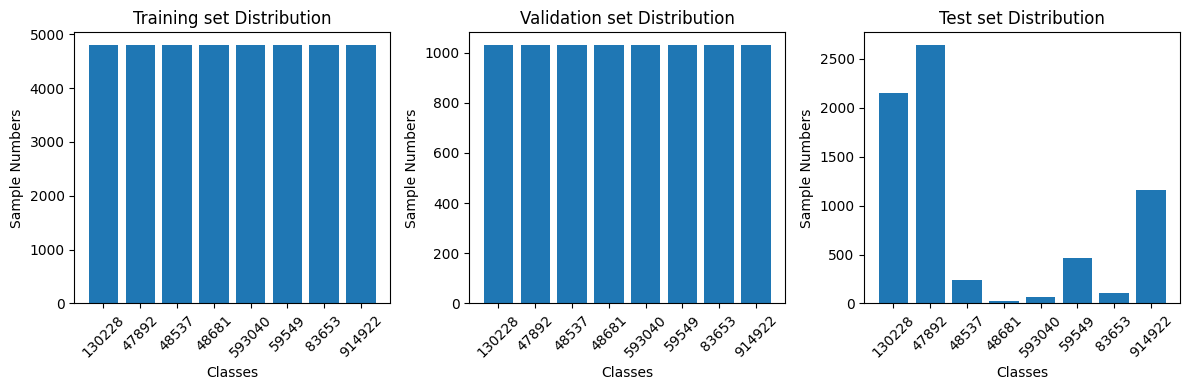

In [38]:
plt.figure(figsize=(12, 4))

# plot for train set
plt.subplot(1, 3, 1)
plt.bar(train_class_counts.keys(), train_class_counts.values())
plt.title('Training set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)

# plot for validation set
plt.subplot(1, 3, 2)
plt.bar(validation_class_counts.keys(), validation_class_counts.values())
plt.title('Validation set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)

# plot for test set
plt.subplot(1, 3, 3)
plt.bar(test_class_counts.keys(), test_class_counts.values())
plt.title('Test set Distribution')
plt.xlabel('Classes')
plt.ylabel('Sample Numbers')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Show some images for testing

In [39]:
# I create train_data above , and I will use it here
label_dict = {y: x for x, y in train_data.class_to_idx.items()}
label_dict

{0: '130228',
 1: '47892',
 2: '48537',
 3: '48681',
 4: '593040',
 5: '59549',
 6: '83653',
 7: '914922'}

In [40]:
# Extract classes from label_dict
classes_to_display = [label_dict[y] for y in range(8)]  # Assuming you want to display the first 8 classes

# Define a function to display images for selected classes
def show_images(images, labels):
    plt.figure(figsize=(12, 8))
    count = 0
    for i in range(len(images)):
        label = labels[i].item()
        if label in classes_to_display:
            plt.subplot(4, 4, count + 1)
            image = to_pil_image(images[i])  # Convert tensor to PIL Image
            plt.imshow(image)
            plt.title(label_dict[label])  # Convert numerical label to string label
            plt.axis('off')
            count += 1
            if count >= len(classes_to_display):  # Break if all classes are displayed
                break
    plt.show()

# Get the first batch
for batch_idx, (images, labels) in enumerate(train_set):
    if batch_idx == 0:  # Only process the first batch
        show_images(images, labels)
        break


<Figure size 1200x800 with 0 Axes>

# Training the model

### Variables and settings

In [41]:
# if GPU is available , use it while training 
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cpu'

In [42]:
# I am going to add accuracies to these lists and I will use them outside of this function 
train_accuracies=[]
validation_accuracies=[]

In [43]:
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)  # total number of images inside of loader
    num_batches = len(dataloader)    # number of batches

    model.train()  # sets the PyTorch model to training mode

    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        # move X and y to GPU for faster training
        X, y = X.to(device), y.to(device)

        # make prediction 
        pred = model(X)
        # calculate loss 
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()   # compute parameters gradients
        optimizer.step()  # update parameters

        # Update training loss
        train_loss += loss.item()  # item() method extracts the loss’s value as a Python float

        # Calculate training accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # loss and accuracy
    train_loss = train_loss / num_batches
    accuracy = 100 * correct / size

    # use this accuracy list for plotting accuracy with matplotlib
    train_accuracies.append(accuracy)

    # Print training accuracy and loss at the end of epoch
    print(f"Training Accuracy: {accuracy:.2f}%, Training Loss: {train_loss:.4f}")

    return train_loss  # Return the training loss

In [44]:
def validation(dataloader, model, loss_fn, t):
    size = len(dataloader.dataset)  # total number of images inside of loader
    num_batches = len(dataloader)    # number of batches

    validation_loss, correct = 0, 0

    # sets the PyTorch model to evaluation mode, it will disable dropout layer
    model.eval()

    with torch.no_grad():  # disable gradient calculation
        for X, y in dataloader:
            # move X and y to GPU for faster training
            X, y = X.to(device), y.to(device)
            pred = model(X)  # make prediction
            validation_loss += loss_fn(pred, y).item()

            # if prediction is correct add 1 to correct variable.
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # loss and accuracy
    validation_loss /= num_batches
    accuracy = 100 * correct / size

    validation_accuracies.append(accuracy)

    # Print test accuracy and loss at the end of epoch
    print(f"Validation Accuracy: {accuracy:.2f}%, Validation Loss: {validation_loss:.4f}")
    
    return validation_loss  # Return the validation loss


### Moddel architecture

In [45]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(SimpleCNN, self).__init__()

        # convolutional layer with 32 filter ,input dimension is 3 because image has 3 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) 
        # activation function , it adds   introduces non-linearity to the model , thus  it helps to model to learn complex functions .
        self.act1 = nn.ReLU() 
        # it reduces pixel number  (90,90)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)  # --> (45,45)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2) # --> (22,22)
        
        # Add four more convolutional layers
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2) # --> (11,11)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.act5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(2) # --> (5,5)
        
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.act6 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(2) # --> (2,2)
        
        self.conv7 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1)
        self.act7 = nn.ReLU()
        self.pool7 = nn.MaxPool2d(2) # --> (1,1)
        
        
        # first flatten the channels and then feed them into the fully connected layer. Given the input shape of (2048, 1, 1), flattening it results in 2048 * 1 * 1.
        self.fc1 = nn.Linear(2048, 256)  
        self.act8 = nn.ReLU()
        
        # dropout drops randomly neurons , here %20 of neurons are dropped randomly . It helps to prevent overfitting
        self.dropout=nn.Dropout(p=0.2) 
        
        # The nn.Linear layer with input size 256 and output size 8 represents the output layer of our neural network. 
        # Since we have 8 classes, the output of this layer will be passed through a softmax activation function.
        # (error function  internally applies softmax activation ,you dont need to add it to here)
        # This converts the raw outputs into probabilities, representing the likelihood of each class. 
        # These probabilities are then used to calculate the error during trainin
        self.fc2 = nn.Linear(256, num_classes) 


    def forward(self, x):
        
        # add outputs on top of each layer and return out in the end
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = self.pool3(self.act3(self.conv3(out)))
        out = self.pool4(self.act4(self.conv4(out)))
        out = self.pool5(self.act5(self.conv5(out)))
        out = self.pool6(self.act6(self.conv6(out)))
        out = self.pool7(self.act7(self.conv7(out)))
        
        out = out.view(out.size(0), -1)
        
        out = self.act8(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# create model
model = SimpleCNN()

# Print the model
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ac

In [46]:
# Load pre-trained ResNet50 model
resnet = models.resnet50(pretrained=True)

# Modify the last fully connected layer to match the number of classes in your dataset
num_classes = 8  # Change this according to your dataset
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Optionally, if you want to freeze the weights of the pre-trained layers
for param in resnet.parameters():
    param.requires_grad = False

class SimpleCNN(nn.Module):
    def __init__(self, backbone, num_classes):
        super(SimpleCNN, self).__init__()
        self.backbone = backbone

        # Add additional layers if needed
        self.fc = nn.Linear(2048, num_classes)  # Input size is fixed for ResNet50

    def forward(self, x):
        features = self.backbone(x)
        out = self.fc(features)
        return out

resnet.fc = nn.Identity()  # Remove the final fully connected layer of ResNet50

# Instantiate your SimpleCNN model with ResNet50 backbone
model = SimpleCNN(resnet, num_classes)

c:\Users\asche\anaconda3\envs\ailab\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\asche\anaconda3\envs\ailab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Test MyCNN

In [47]:
# Lists to store the training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [48]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-4)  # Adding weight decay

In [49]:
num_epochs = 100

In [50]:
# Initialize variables for early stopping
best_loss = float("inf")
patience = 3
counter = 0

In [51]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    
    for images, labels in train_set:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = F.cross_entropy(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        total_loss += loss.item() * images.size(0)
        
        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
    
    epoch_loss = total_loss / len(train_data)
    train_accuracy = correct_train / len(train_data)
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    
    # Validation phase
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    
    with torch.no_grad():
        for val_images, val_labels in validation_set:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = F.cross_entropy(val_outputs, val_labels)
            total_val_loss += val_loss.item() * val_images.size(0)
            
            # Compute validation accuracy
            _, predicted_val = torch.max(val_outputs, 1)
            correct_val += (predicted_val == val_labels).sum().item()
    
    val_loss = total_val_loss / len(validation_data)
    val_accuracy = correct_val / len(validation_data)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

print("Training completed.")


Epoch 1/100, Training Loss: 1.0601, Training Accuracy: 0.6550
Validation Loss: 0.8719, Validation Accuracy: 0.7008
Epoch 2/100, Training Loss: 0.7994, Training Accuracy: 0.7293
Validation Loss: 0.7927, Validation Accuracy: 0.7253
Epoch 3/100, Training Loss: 0.7456, Training Accuracy: 0.7455
Validation Loss: 0.7637, Validation Accuracy: 0.7346
Epoch 4/100, Training Loss: 0.7129, Training Accuracy: 0.7554
Validation Loss: 0.7649, Validation Accuracy: 0.7290
Epoch 5/100, Training Loss: 0.6899, Training Accuracy: 0.7613
Validation Loss: 0.7758, Validation Accuracy: 0.7236
Epoch 6/100, Training Loss: 0.6672, Training Accuracy: 0.7692
Validation Loss: 0.7295, Validation Accuracy: 0.7426
Epoch 7/100, Training Loss: 0.6548, Training Accuracy: 0.7723
Validation Loss: 0.7541, Validation Accuracy: 0.7308
Epoch 8/100, Training Loss: 0.6402, Training Accuracy: 0.7773
Validation Loss: 0.7408, Validation Accuracy: 0.7409
Epoch 9/100, Training Loss: 0.6268, Training Accuracy: 0.7823
Validation Loss: 0

In [52]:
# Save the model after training
torch.save(model, './models/trained_model1b.pth')
print("Model 1b saved!")

Model 1b saved!


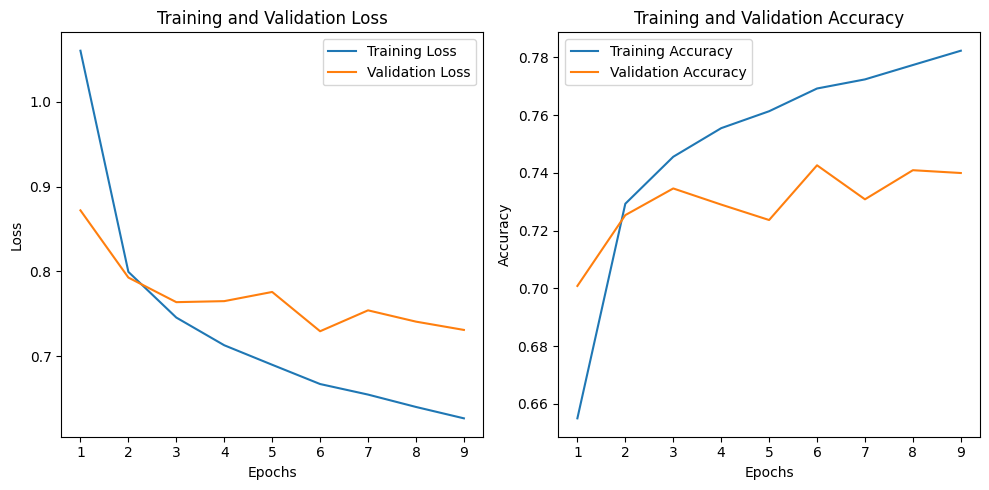

In [53]:
# Plotting the training and validation metrics
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:
import matplotlib.pyplot as plt 

def visualize(train_accuracies,validation_accuracies):
    epoch_number=len(train_accuracies)

    plt.plot(range(1,epoch_number+1),train_accuracies,'r', label='Training accuracy')
    plt.plot(range(1,epoch_number+1),validation_accuracies,'b', label='Validation accuracy')
    plt.legend()
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracies")
    plt.grid()

ValueError: x and y must have same first dimension, but have shapes (9,) and (0,)

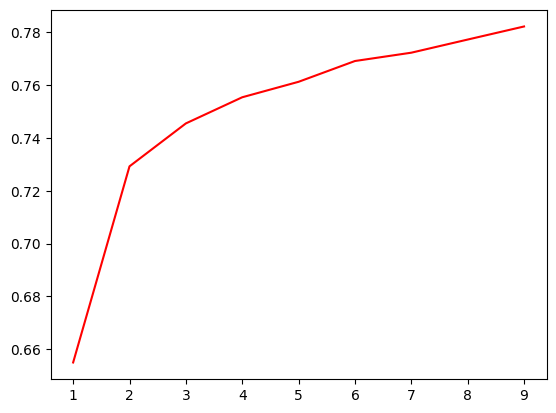

In [55]:
# Remember , this 2 parameters are lists , I created them above and append values to them regularly
visualize(train_accuracies,validation_accuracies)

In [58]:
import os
import pickle
import matplotlib.pyplot as plt

filename = 'model1b_losses.csv'

def save_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies, filename):
    data = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }
    
    with open(filename, 'wb') as file:
        pickle.dump(data, file)
    print(f"Data saved to {filename}")

def plot_losses(train_losses, val_losses):
    iterations = range(1, len(train_losses) + 1)
    plt.plot(iterations, train_losses, marker='o', linestyle='-', label='Training Loss')
    plt.plot(iterations, val_losses, marker='o', linestyle='-', label='Validation Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracies(train_accuracies, val_accuracies):
    iterations = range(1, len(train_accuracies) + 1)
    plt.plot(iterations, train_accuracies, marker='o', linestyle='-', label='Training Accuracy')
    plt.plot(iterations, val_accuracies, marker='o', linestyle='-', label='Validation Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.grid(True)
    plt.show()

Data saved to model1b_losses.csv


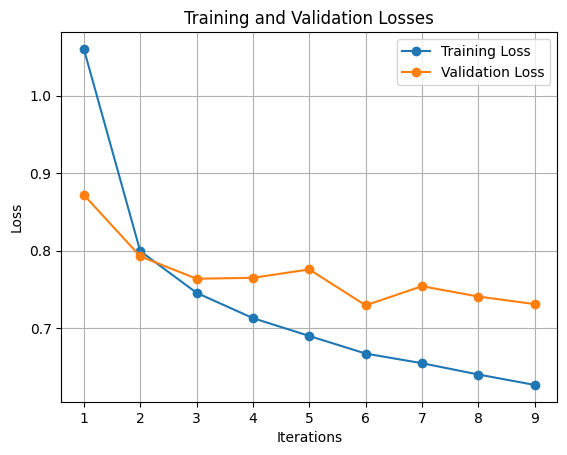

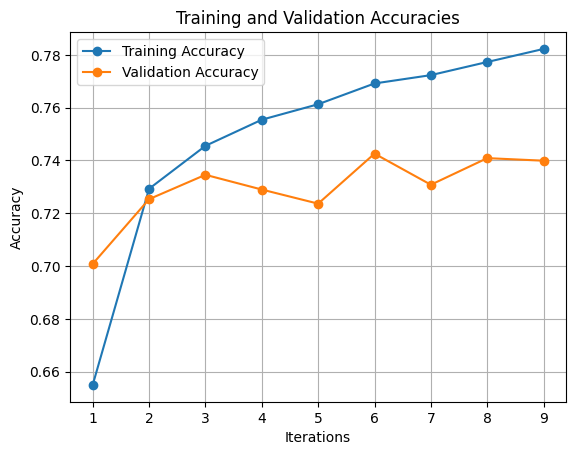

In [59]:
# Saving data
save_losses_accuracies(train_losses, val_losses, train_accuracies, val_accuracies, filename)

# Plotting
plot_losses(train_losses, val_losses)
plot_accuracies(train_accuracies, val_accuracies)